In [230]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression  

In [231]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [283]:
M = 9 # Number of Spiking motifs
N = 100 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 100 # hz
pg_fr = 100 # hz
background_noise_fr = 900 # hz

np.random.seed(41)

# colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])




In [284]:
num_trials = 1

N_array = [100,120,150,200,500]
M_array = [10,15,20,25,30,50]
D_array = [31,51,71,91,101,121]
T_array = [1000,2000,3000,4000,5000]
nrn_fr_array = [20,25,30,40,50,70,90]
pg_fr_array = [4,8,16,32,64,100]
background_noise_fr_array=[10,50,100,200,400,800]

parameter = pg_fr_array

performance = np.zeros((len(parameter),num_trials))

for idc, pg_fr in enumerate(parameter):


    for trial in tqdm(range(num_trials)):


        '''
        Generate the PG Kernels
        '''

        K_dense = np.random.randint(0,999,(N,D,M))
        K_dense[K_dense < nrn_fr] = 1
        K_dense[K_dense >= nrn_fr] = 0
        K_sparse = np.where(K_dense)

        '''
        Generate the PG occurrences
        '''
        
        condition=True
        while condition:
            B_dense = np.random.randint(0,999,(M,T))
            B_dense[B_dense < pg_fr] = 1
            B_dense[B_dense != 1] = 0
            B_sparse = np.where(B_dense)
            if len(np.unique(B_sparse[0])) == M:
                condition = False

        '''
        Convolve the PG kernels with the PG firing times
        '''

        # now to make the full raster plot keeping the labels in-tact
        # dense A: the layered binary images of all neuron spikes by PG ( N x T x M)
        A_dense = np.zeros((N,T+D,M+1))
        A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
        A_dense[...,-1][A_dense[...,-1]<background_noise_fr] =1
        A_dense[...,-1][A_dense[...,-1]!=1] = 0
        for i in range(len(B_sparse[0])):
            t = B_sparse[1][i]
            b = B_sparse[0][i]
            A_dense[:, t:t+D, b] += K_dense[...,b]

        A_dense.shape
        # A_dense = A_dense[:,:1000,:]
        A_sparse = np.where(A_dense)
        A_dense = np.sum(A_dense,axis=2)
        A_dense[A_dense>1] = 1
        A_dense.shape


        '''
        Prepare the data for logistic regression
        '''

        x = [np.zeros((T,N,D)) for k in range(M)]
        y = [np.zeros((T)) for k in range(M)]
        for j in range(M):
            for i in range(T):
                x[j][i,...] = A_dense[:,i:D+i]
            y[j] = B_dense[j,:]
            x[j]=x[j].reshape(x[j].shape[0],x[j].shape[1]*x[j].shape[2])
        x[0].shape, y[0].shape

        w= []
        y_pred = []

        for j in range(M):
            x_train = torch.from_numpy(x[j].astype(np.float32))
            y_train = torch.from_numpy(y[j].astype(np.float32))
            
            
            classifier= LogisticRegression(max_iter=5000, random_state=0)  

            classifier.fit(x_train, y_train.ravel()) 
            y_pred.append(classifier.predict(x[j]))

            w.append(classifier.coef_)
            w[-1] = w[-1].T
            w[-1] = w[-1].reshape(N,D)
        w = np.array(w)
        y_pred = np.array(y_pred)
        performance[idc,trial] = ((np.sum(B_dense) - np.sum(np.abs(B_dense - y_pred))) /np.sum(B_dense))


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


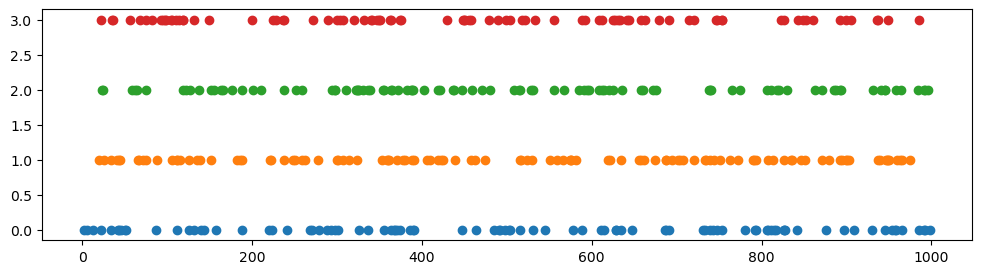

In [286]:
plt.figure(figsize=(12,3))
[plt.scatter(B_sparse[1][B_sparse[0]==i],B_sparse[0][B_sparse[0]==i],c=colors[i]) for i in range(4)]
plt.show()

In [288]:
np.array([parameter for k in range(performance.shape[1])]).T.shape, performance.shape

((6, 1), (6, 1))

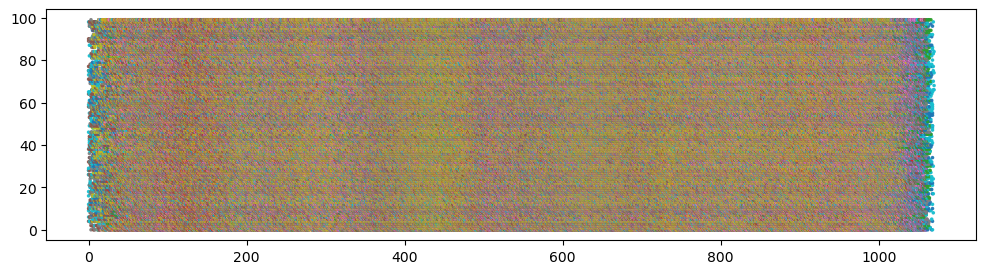

In [289]:
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=10,marker='.')
plt.show()

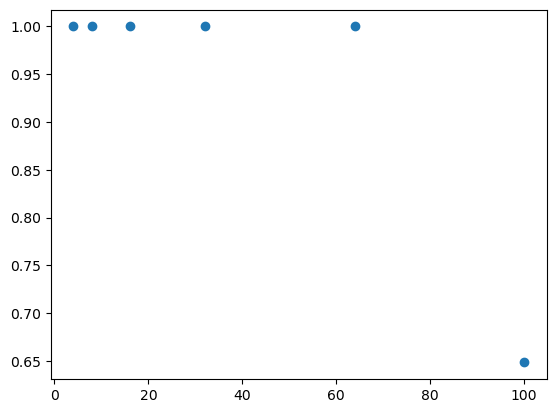

In [290]:
plt.figure()
plt.scatter(np.array([parameter for k in range(performance.shape[1])]),performance)

<BarContainer object of 10 artists>

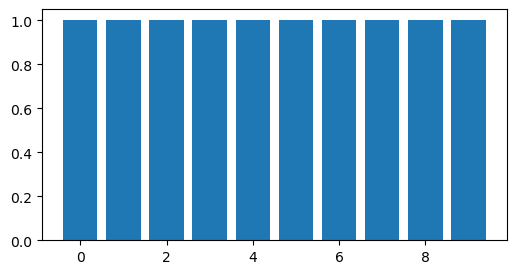

In [184]:
plt.figure(figsize=(6,3))
plt.bar(np.arange(0,len(performance)),performance)

In [180]:
performance

[17.0, 20.0, 13.0, 12.0, 18.0, 13.0, 15.0, 10.0, 18.0, 17.0]

okay... sklearn's logistic regression funtction is blazing fast, and performs better than pytorch's ... What am I doing wrong lol


# Performance

In [137]:
(np.sum(B_dense) - np.sum(np.abs(B_dense - y_pred)))/np.sum(B_dense)

0.8823529411764706

In [138]:
B_dense.shape

(4, 1000)